## **Carga de datos**

In [1]:
import pandas as pd

df = pd.read_csv("full_multilabel_df.csv")
df.fillna(0, inplace=True)

In [2]:
index_out = df[df['database'] == 'ESC'].index.tolist()
# Drop indices from DataFrame
df.drop(index_out, inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
df['database'].value_counts()

database
INTER1SP    6041
SMC         5129
EMS         2005
EW          1992
MESD         862
EmoFilm      359
Name: count, dtype: int64

In [4]:
df['duration'].mean(), df['duration'].median()

(5.211983456824985, 3.6867573696145124)

In [5]:
df['new_emotion'].value_counts()

new_emotion
neutral      5581
disgust      2265
anger        1937
happiness    1910
sadness      1863
fear         1807
surprise     1025
Name: count, dtype: int64

In [6]:
import numpy as np

features = np.load("full_multilabel_w2v2_53es_layer6.npz")
features = list(features.values())

In [7]:
# Remove corresponding indices from features
features = np.delete(features, index_out, axis=0)

In [8]:
# Verify alignment
assert len(df) == features.shape[0], "Mismatch between df and features length"

## **Preparación de datos**

### **NO se añaden perfiles del hablante**

In [27]:
n_dbs = ['SMC', 'ESCorpus']
a_dbs = ['EMS', 'MESD', 'INTER1SP', 'EmoFilm']
i_dbs = ['EmoWisconsin']

df['type_emotion'] = df['database'].apply(lambda x: 'natural' if x in n_dbs else ('acted' if x in a_dbs else 'induced'))

In [9]:
from sklearn.model_selection import train_test_split

# Codificar emociones y género como variables dummy (0/1)
y= df["new_emotion"]

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, shuffle=True, stratify=df['new_emotion'])

# Extraer las rutas correspondientes al conjunto de prueba
_, test_paths = train_test_split(df["path"], test_size=0.2, random_state=42)
test_paths = test_paths.reset_index(drop=True)

# Obtener los mismos índices que se usaron en el split original
indices = np.arange(len(df))

# Reproducir el split usando solo índices
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

# Ahora puedes indexar cualquier columna del DataFrame original
test_databases = df.iloc[test_idx]['database'].reset_index(drop=True)

In [10]:
y_train.to_csv("train_baseline.csv", index=False)
y_test.to_csv("test_baseline.csv", index=False)

In [11]:
from sklearn.preprocessing import StandardScaler

# Escalado de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


In [12]:
X_train.shape, y_train.shape

((13110, 1024), (13110,))

## **Entrenamiento**
{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (512, 256, 256), 'estimator__learning_rate_init': 0.001}


In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, f1_score

mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(512, 256, 256),
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
    
)


mlp.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(512, 256, 256), max_iter=1000,
              random_state=42)

# **Gráficas**

In [14]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

y_pred = mlp.predict(X_test)

# ======= Reporte Emociones ========
print("\n===== Reporte de EMOCIONES =====")

print(classification_report(y_test, y_pred, digits=6))

print("Accuracy (Emociones):", accuracy_score(y_test, y_pred))
print("Hamming Loss (Emociones):", hamming_loss(y_test, y_pred))
print("F1 weighted (Emociones):", f1_score(y_test, y_pred, average="weighted"))


===== Reporte de EMOCIONES =====
              precision    recall  f1-score   support

       anger   0.900277  0.837629  0.867824       388
     disgust   0.872017  0.887417  0.879650       453
        fear   0.822535  0.808864  0.815642       361
   happiness   0.913947  0.806283  0.856745       382
     neutral   0.870569  0.946237  0.906827      1116
     sadness   0.896552  0.836461  0.865465       373
    surprise   0.906404  0.897561  0.901961       205

    accuracy                       0.878279      3278
   macro avg   0.883186  0.860065  0.870588      3278
weighted avg   0.879248  0.878279  0.877566      3278

Accuracy (Emociones): 0.8782794386821232
Hamming Loss (Emociones): 0.12172056131787676
F1 weighted (Emociones): 0.8775655530367231


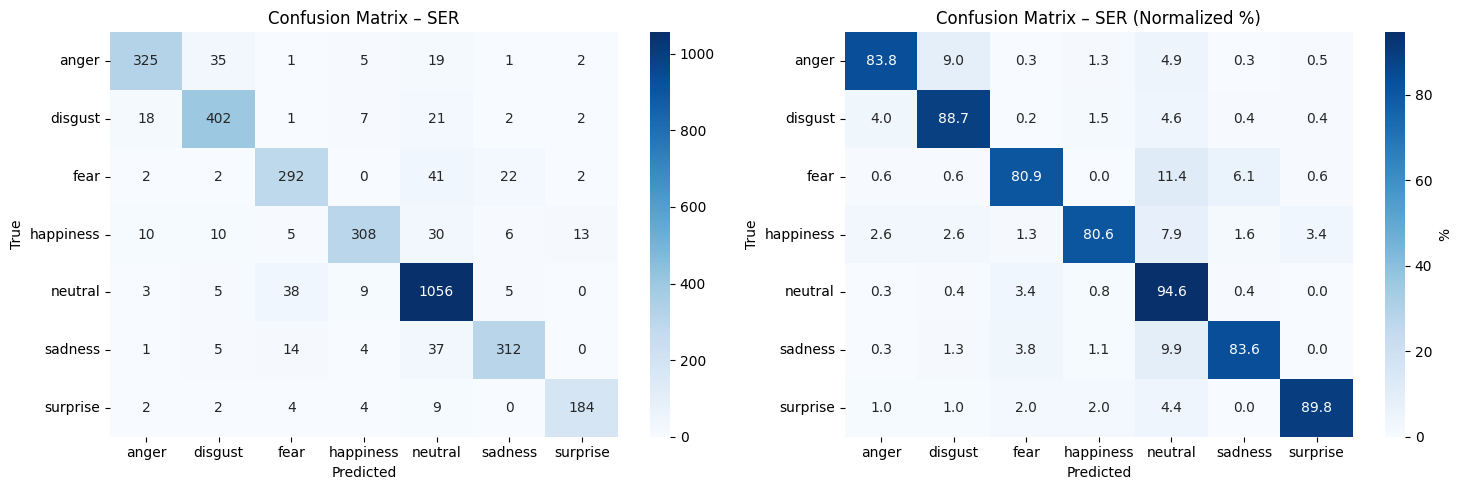

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener etiquetas ordenadas
labels = np.unique(y_test)

# Calcular matrices de confusión
cm_emotion = confusion_matrix(y_test, y_pred, labels=labels)
cm_emotion_norm = cm_emotion.astype('float') / cm_emotion.sum(axis=1, keepdims=True)

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- Matriz nominal ---
sns.heatmap(cm_emotion, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Confusion Matrix – SER")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# --- Matriz porcentual ---
sns.heatmap(cm_emotion_norm * 100, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1], cbar_kws={'label': '%'})
axes[1].set_title("Confusion Matrix – SER (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Estilo general
plt.tight_layout()
plt.show()


---
---

Resultados por base de datos

In [17]:
mask

0       False
1       False
2       False
3       False
4       False
        ...  
3273    False
3274    False
3275    False
3276    False
3277    False
Name: database, Length: 3278, dtype: bool


=== Classification Report for EMS ===
              precision    recall  f1-score   support

       anger     0.8980    0.8302    0.8627        53
     disgust     0.8500    0.9107    0.8793        56
        fear     0.8261    0.9048    0.8636        42
   happiness     0.9500    0.7917    0.8636        48
     neutral     0.9023    0.9677    0.9339       124
     sadness     0.9394    0.8611    0.8986        36
    surprise     0.9091    0.8333    0.8696        24

    accuracy                         0.8930       383
   macro avg     0.8964    0.8714    0.8816       383
weighted avg     0.8956    0.8930    0.8922       383

Accuracy: 0.8930
Hamming Loss: 0.1070
Weighted F1-score: 0.8922
Micro F1-score:    0.8930


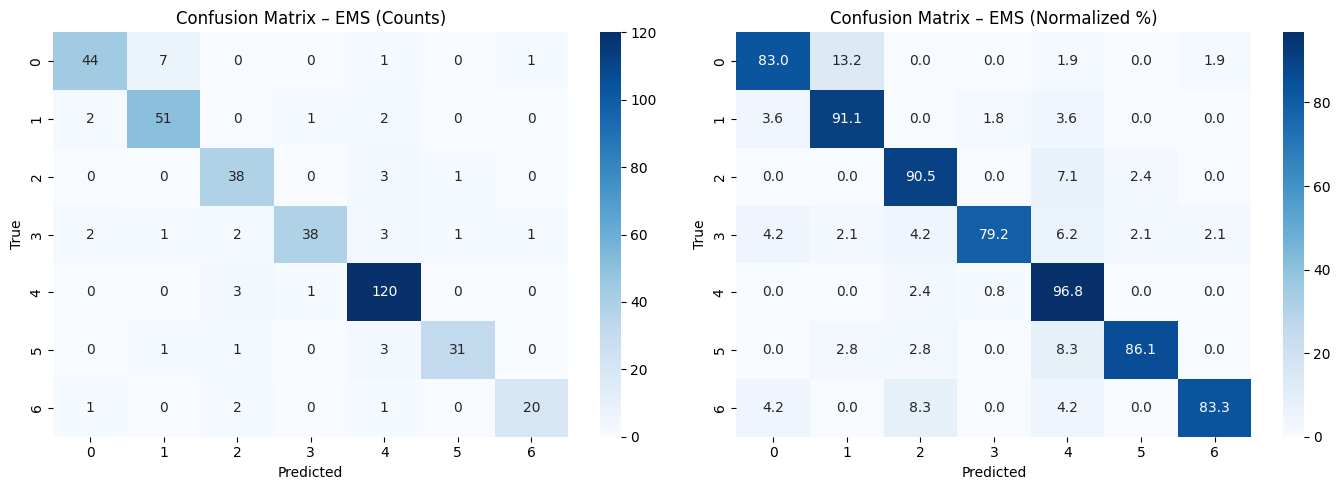


=== Classification Report for EW ===
              precision    recall  f1-score   support

       anger     0.8500    0.7907    0.8193        43
     disgust     0.8413    0.9138    0.8760        58
        fear     0.8000    0.6486    0.7164        37
   happiness     0.9474    0.8182    0.8780        44
     neutral     0.8503    0.9470    0.8961       132
     sadness     0.8750    0.8140    0.8434        43
    surprise     0.9615    0.9259    0.9434        27

    accuracy                         0.8646       384
   macro avg     0.8751    0.8369    0.8532       384
weighted avg     0.8658    0.8646    0.8625       384

Accuracy: 0.8646
Hamming Loss: 0.1354
Weighted F1-score: 0.8625
Micro F1-score:    0.8646


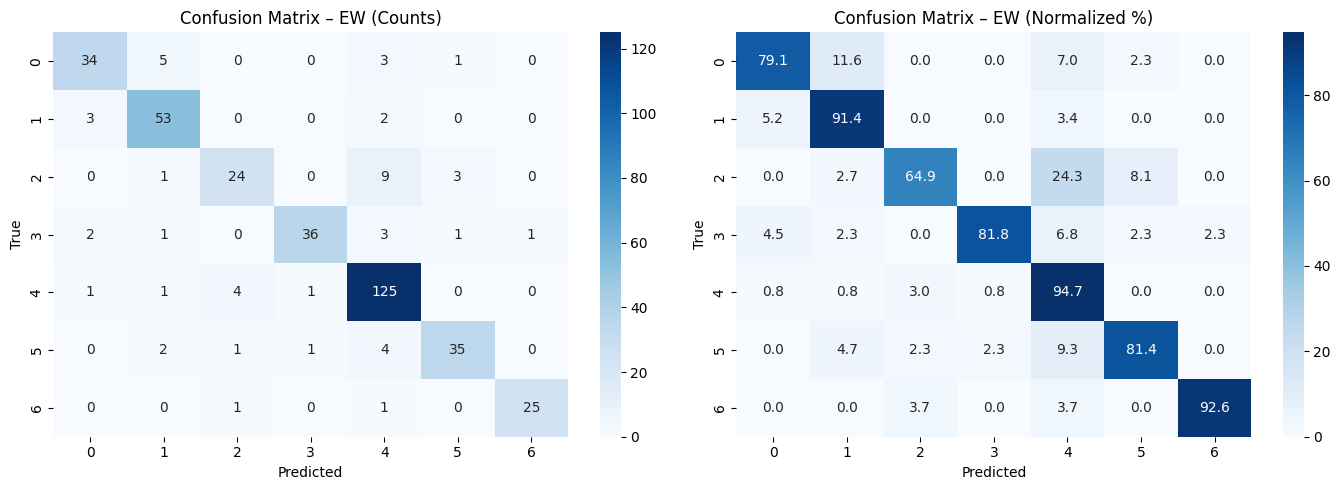


=== Classification Report for EmoFilm ===
              precision    recall  f1-score   support

       anger     0.8750    0.8750    0.8750         8
     disgust     1.0000    0.8889    0.9412         9
        fear     0.8889    0.8000    0.8421        10
   happiness     0.8333    0.7143    0.7692         7
     neutral     0.7812    1.0000    0.8772        25
     sadness     1.0000    0.5000    0.6667         8
    surprise     1.0000    1.0000    1.0000         4

    accuracy                         0.8592        71
   macro avg     0.9112    0.8255    0.8531        71
weighted avg     0.8768    0.8592    0.8527        71

Accuracy: 0.8592
Hamming Loss: 0.1408
Weighted F1-score: 0.8527
Micro F1-score:    0.8592


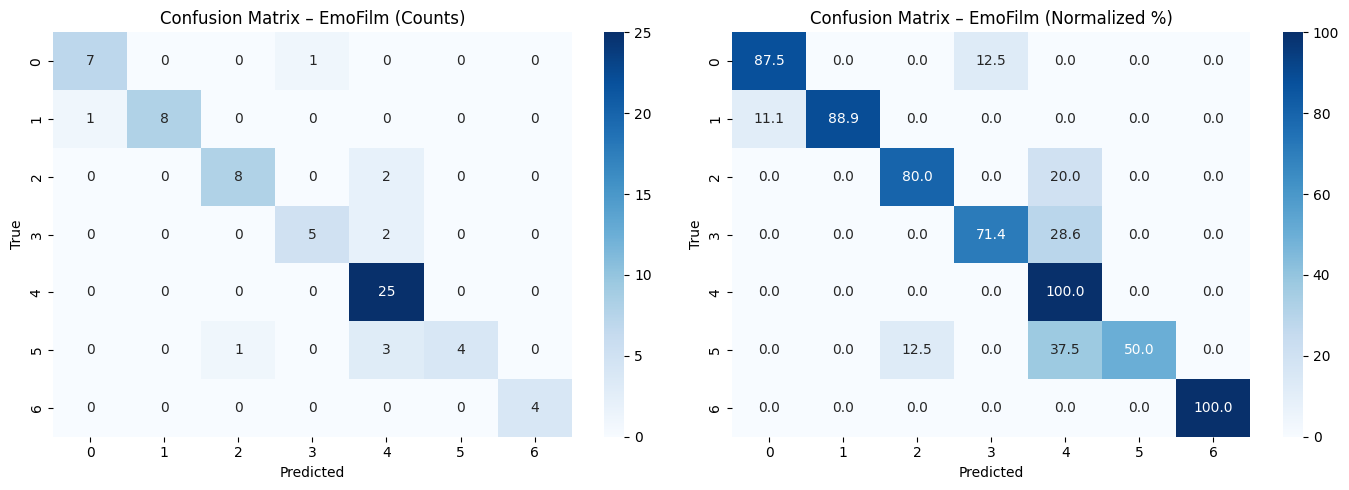


=== Classification Report for INTER1SP ===
              precision    recall  f1-score   support

       anger     0.9286    0.8966    0.9123       145
     disgust     0.8902    0.8795    0.8848       166
        fear     0.8058    0.8296    0.8175       135
   happiness     0.8976    0.8261    0.8604       138
     neutral     0.8847    0.9238    0.9038       407
     sadness     0.8779    0.8394    0.8582       137
    surprise     0.8933    0.9178    0.9054        73

    accuracy                         0.8826      1201
   macro avg     0.8826    0.8733    0.8775      1201
weighted avg     0.8831    0.8826    0.8824      1201

Accuracy: 0.8826
Hamming Loss: 0.1174
Weighted F1-score: 0.8824
Micro F1-score:    0.8826


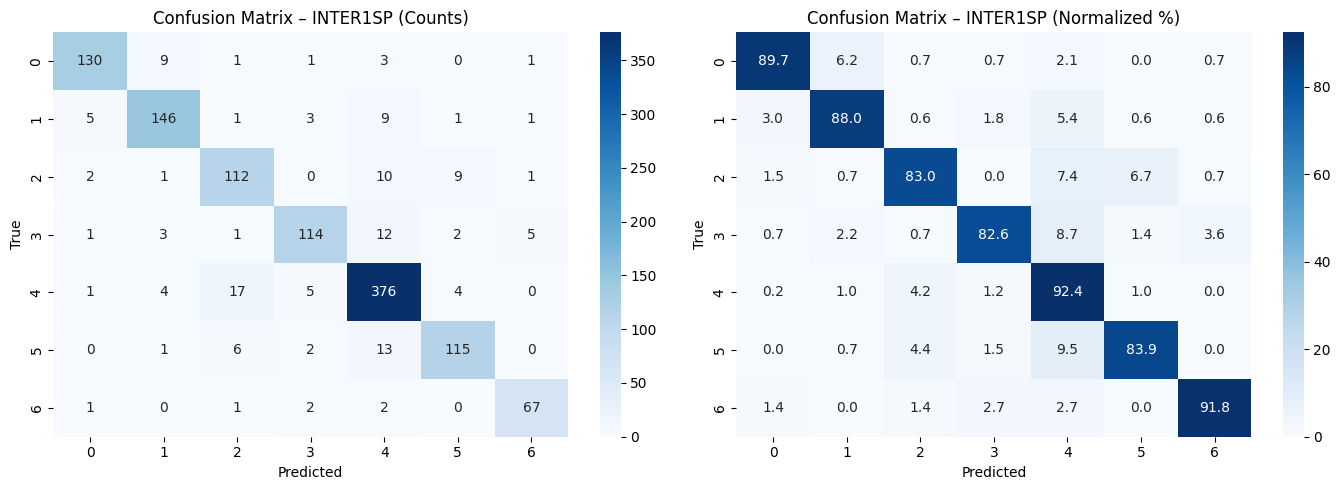


=== Classification Report for MESD ===
              precision    recall  f1-score   support

       anger     0.9333    0.8235    0.8750        17
     disgust     0.8095    1.0000    0.8947        17
        fear     0.7895    0.8824    0.8333        17
   happiness     0.9286    0.7222    0.8125        18
     neutral     0.9167    0.9429    0.9296        70
     sadness     0.9524    0.8696    0.9091        23
    surprise     1.0000    1.0000    1.0000        10

    accuracy                         0.9012       172
   macro avg     0.9043    0.8915    0.8935       172
weighted avg     0.9060    0.9012    0.9003       172

Accuracy: 0.9012
Hamming Loss: 0.0988
Weighted F1-score: 0.9003
Micro F1-score:    0.9012


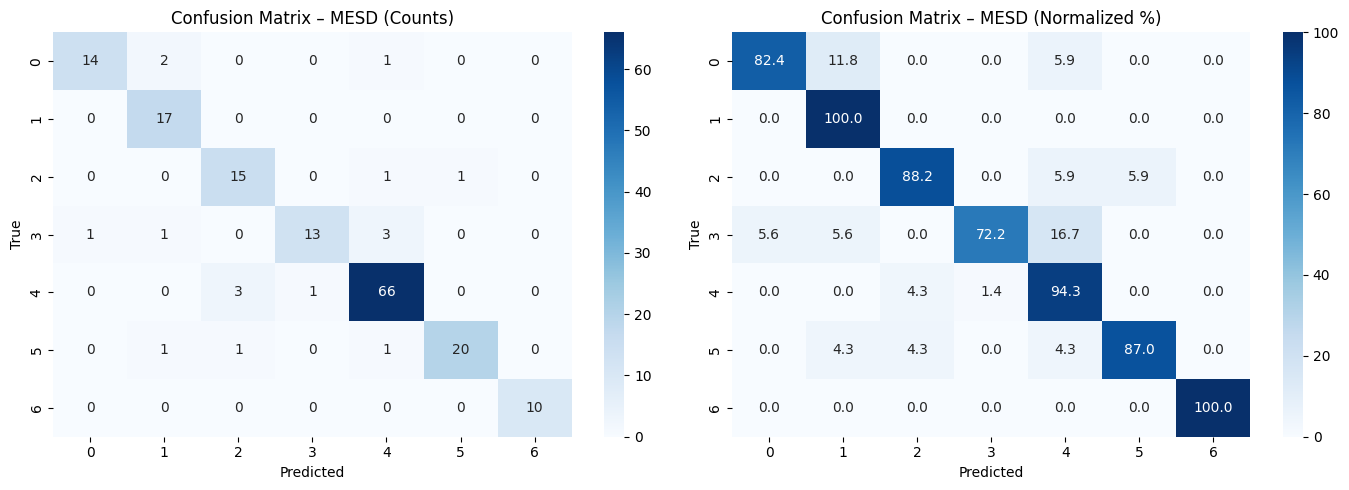


=== Classification Report for SMC ===
              precision    recall  f1-score   support

       anger     0.8807    0.7869    0.8312       122
     disgust     0.8759    0.8639    0.8699       147
        fear     0.8482    0.7917    0.8190       120
   happiness     0.9107    0.8031    0.8536       127
     neutral     0.8515    0.9609    0.9029       358
     sadness     0.8992    0.8492    0.8735       126
    surprise     0.8788    0.8657    0.8722        67

    accuracy                         0.8707      1067
   macro avg     0.8779    0.8459    0.8603      1067
weighted avg     0.8722    0.8707    0.8694      1067

Accuracy: 0.8707
Hamming Loss: 0.1293
Weighted F1-score: 0.8694
Micro F1-score:    0.8707


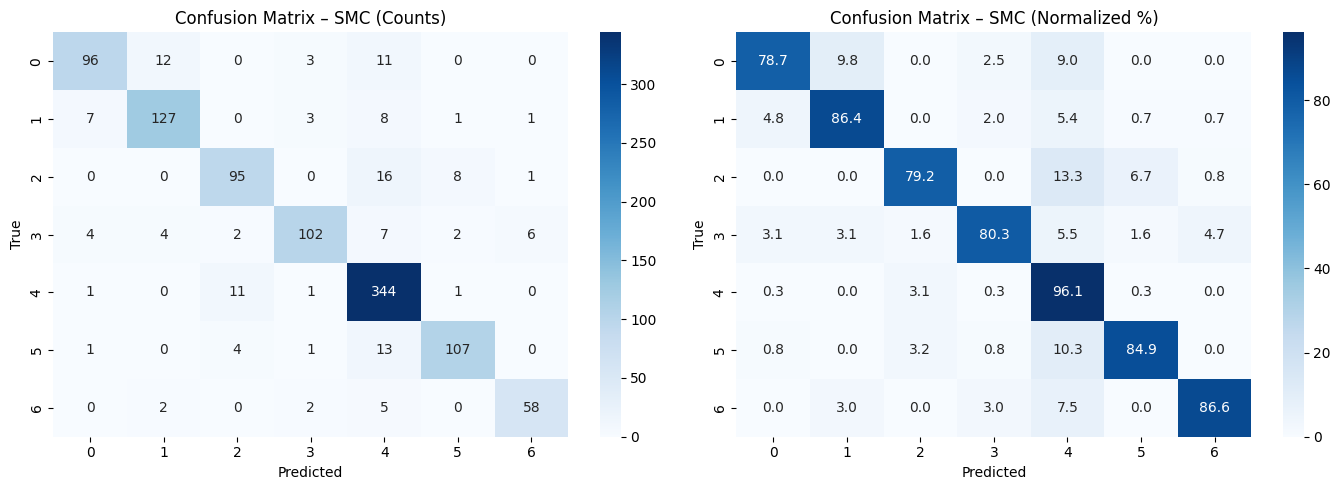

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


unique_dbs = np.unique(test_databases)

for db in unique_dbs:
    # Filtrar muestras por base de datos
    mask = test_databases == db
    emo_t = y_test.values[mask]
    emo_p = y_pred[mask]

    print(f"\n=== Classification Report for {db} ===")
    print(classification_report(emo_t, emo_p, digits=4))

    print(f"Accuracy: {accuracy_score(emo_t, emo_p):.4f}")
    print(f"Hamming Loss: {hamming_loss(emo_t, emo_p):.4f}")
    print(f"Weighted F1-score: {f1_score(emo_t, emo_p, average='weighted'):.4f}")
    print(f"Micro F1-score:    {f1_score(emo_t, emo_p, average='micro'):.4f}")


    # Confusion matrices
    cm = confusion_matrix(emo_t, emo_p,)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot ambas matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(cm, annot=True, fmt='d',
                cmap='Blues', ax=axes[0])
    axes[0].set_title(f"Confusion Matrix – {db} (Counts)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    sns.heatmap(cm_norm * 100, annot=True, fmt='.1f',
                cmap='Blues', ax=axes[1])
    axes[1].set_title(f"Confusion Matrix – {db} (Normalized %)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

---
---

Resultados por tipo de base de datos


=== Classification Report for acted ===
              precision    recall  f1-score   support

       anger     0.9198    0.8744    0.8966       223
     disgust     0.8775    0.8952    0.8862       248
        fear     0.8122    0.8480    0.8297       204
   happiness     0.9091    0.8057    0.8543       211
     neutral     0.8867    0.9377    0.9115       626
     sadness     0.8995    0.8333    0.8651       204
    surprise     0.9099    0.9099    0.9099       111

    accuracy                         0.8856      1827
   macro avg     0.8878    0.8720    0.8790      1827
weighted avg     0.8866    0.8856    0.8852      1827

Accuracy: 0.8856
Hamming Loss: 0.1144
Weighted F1-score: 0.8852
Micro F1-score:    0.8856


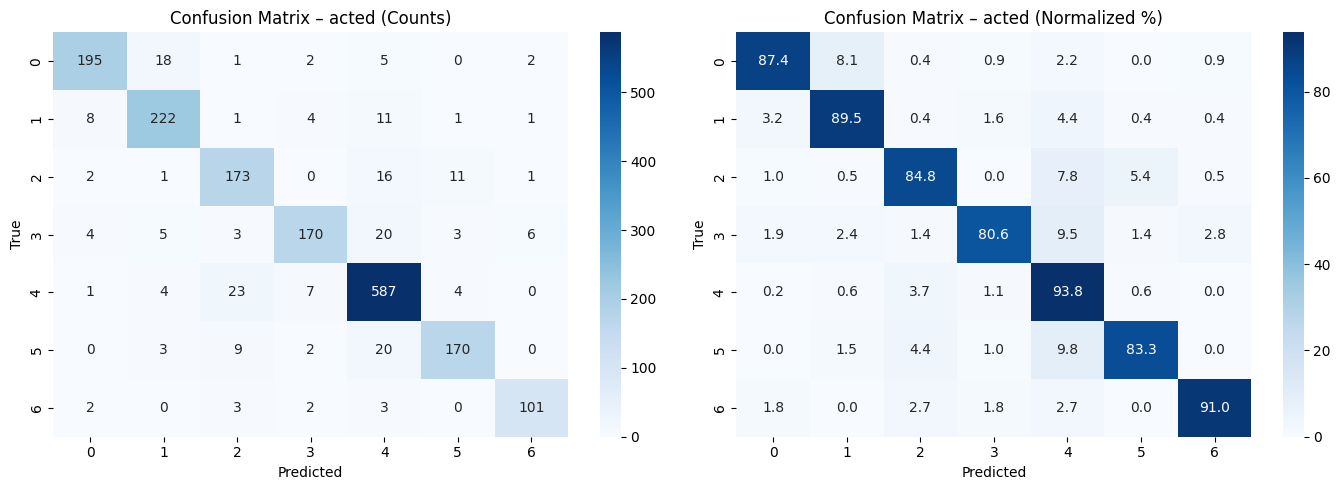


=== Classification Report for induced ===
              precision    recall  f1-score   support

       anger     0.8500    0.7907    0.8193        43
     disgust     0.8413    0.9138    0.8760        58
        fear     0.8000    0.6486    0.7164        37
   happiness     0.9474    0.8182    0.8780        44
     neutral     0.8503    0.9470    0.8961       132
     sadness     0.8750    0.8140    0.8434        43
    surprise     0.9615    0.9259    0.9434        27

    accuracy                         0.8646       384
   macro avg     0.8751    0.8369    0.8532       384
weighted avg     0.8658    0.8646    0.8625       384

Accuracy: 0.8646
Hamming Loss: 0.1354
Weighted F1-score: 0.8625
Micro F1-score:    0.8646


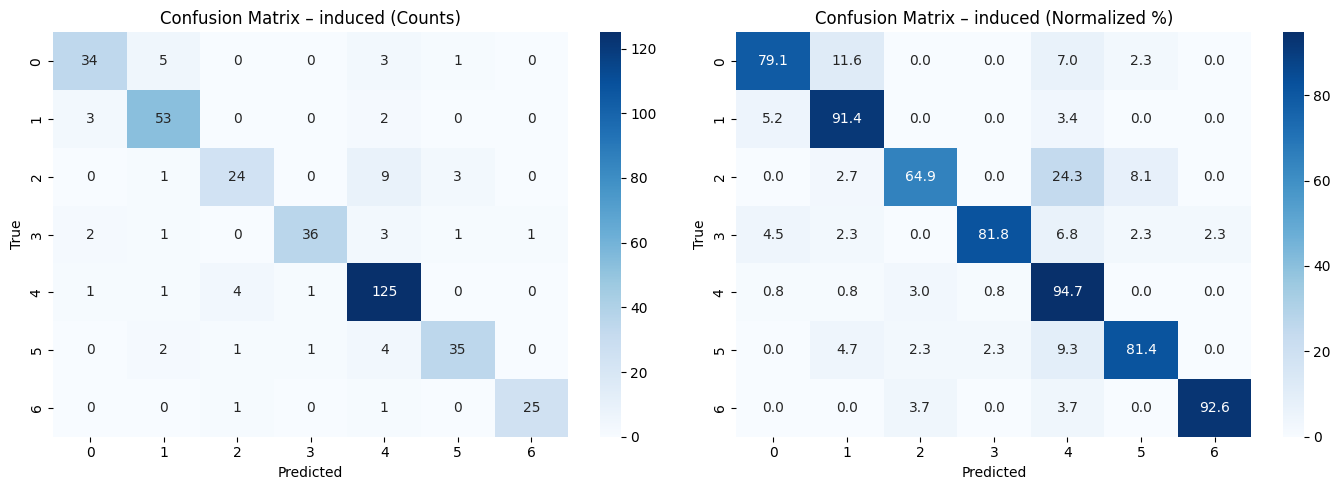


=== Classification Report for natural ===
              precision    recall  f1-score   support

       anger     0.8807    0.7869    0.8312       122
     disgust     0.8759    0.8639    0.8699       147
        fear     0.8482    0.7917    0.8190       120
   happiness     0.9107    0.8031    0.8536       127
     neutral     0.8515    0.9609    0.9029       358
     sadness     0.8992    0.8492    0.8735       126
    surprise     0.8788    0.8657    0.8722        67

    accuracy                         0.8707      1067
   macro avg     0.8779    0.8459    0.8603      1067
weighted avg     0.8722    0.8707    0.8694      1067

Accuracy: 0.8707
Hamming Loss: 0.1293
Weighted F1-score: 0.8694
Micro F1-score:    0.8707


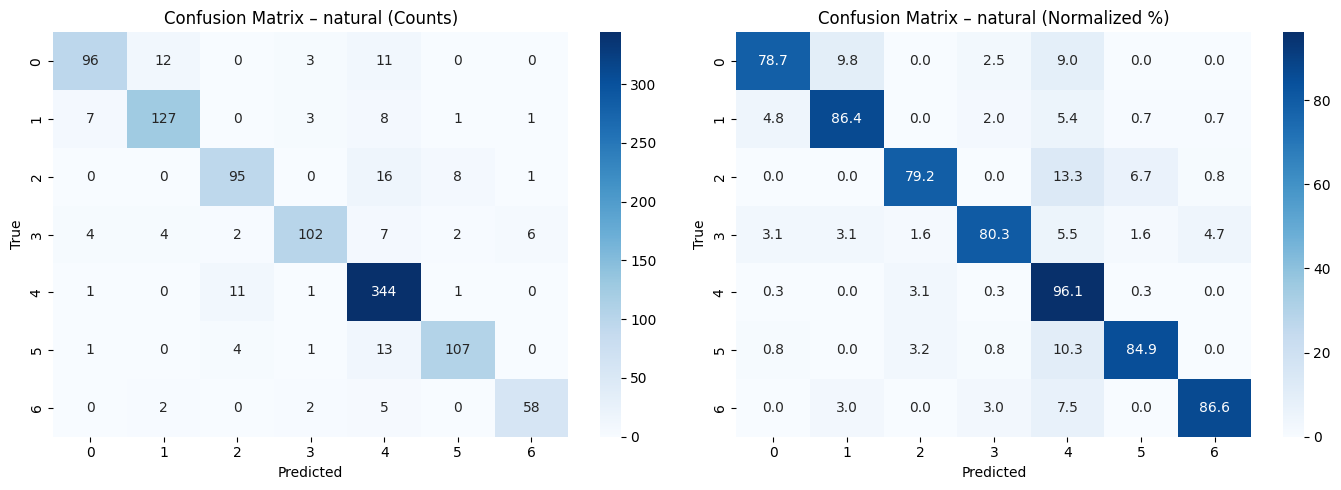

In [28]:
# Ahora puedes indexar cualquier columna del DataFrame original
test_types = df.iloc[test_idx]['type_emotion'].reset_index(drop=True)


unique_types = np.unique(test_types)

for db in unique_types:
    # Filtrar muestras por base de datos
    mask = test_types == db
    emo_t = y_test.values[mask]
    emo_p = y_pred[mask]

    print(f"\n=== Classification Report for {db} ===")
    print(classification_report(emo_t, emo_p, digits=4))

    print(f"Accuracy: {accuracy_score(emo_t, emo_p):.4f}")
    print(f"Hamming Loss: {hamming_loss(emo_t, emo_p):.4f}")
    print(f"Weighted F1-score: {f1_score(emo_t, emo_p, average='weighted'):.4f}")
    print(f"Micro F1-score:    {f1_score(emo_t, emo_p, average='micro'):.4f}")


    # Confusion matrices
    cm = confusion_matrix(emo_t, emo_p, )
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot ambas matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.heatmap(cm, annot=True, fmt='d',
                cmap='Blues', ax=axes[0])
    axes[0].set_title(f"Confusion Matrix – {db} (Counts)")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    sns.heatmap(cm_norm * 100, annot=True, fmt='.1f',
                cmap='Blues', ax=axes[1])
    axes[1].set_title(f"Confusion Matrix – {db} (Normalized %)")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()

---
---

# **Guardar resultados**

In [74]:
results = pd.DataFrame({"y_true": y_test,
                        "y_pred": y_pred})

results.to_csv("preds_monolabel.csv")